In [1]:
import laspy
import matplotlib.pyplot as plt
import numpy as np
import src.visualization.clouds
import torch
import torch_geometric
from matplotlib.colors import ListedColormap

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.visualization.clouds
%aimport src.clouds

In [4]:
las = laspy.read("../../data/interim/trees/aspen_08.las")
las = las[las.xyz[:, 2] >= 2]
rgb = np.transpose(np.stack([las.red, las.green, las.blue])) / 255
data = torch_geometric.data.Data(
    pos=torch.from_numpy(src.clouds.recenter_cloud(las.xyz)),
    x=torch.from_numpy(rgb),
)

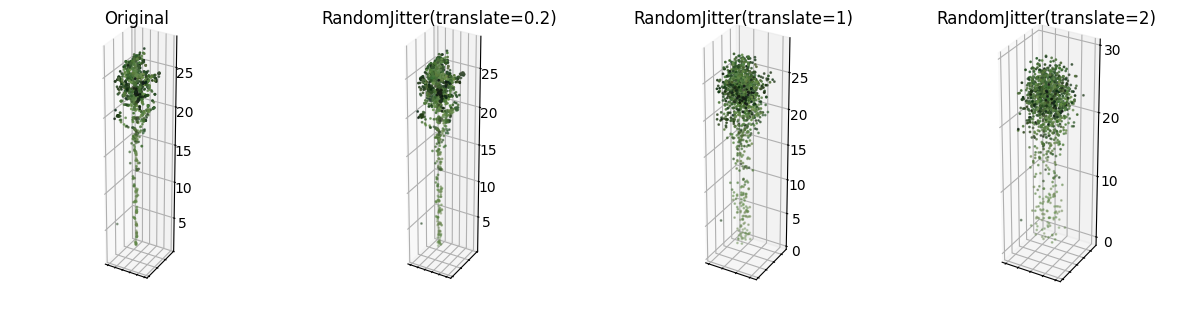

In [5]:
#| include: true
#| label: fig-random-jitter-effect
#| fig-cap: Visualization of the random jitter augmentation on a single aspen tree. The
#|   translation magnitude is uniformly sampled from a set range for every point.

fig = plt.figure(figsize=(15, 10))

params = [
    0,
    0.2,
    1,
    2,
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomJitter(x)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
    else:
        ax.set_title(f"RandomJitter(translate={x})")
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

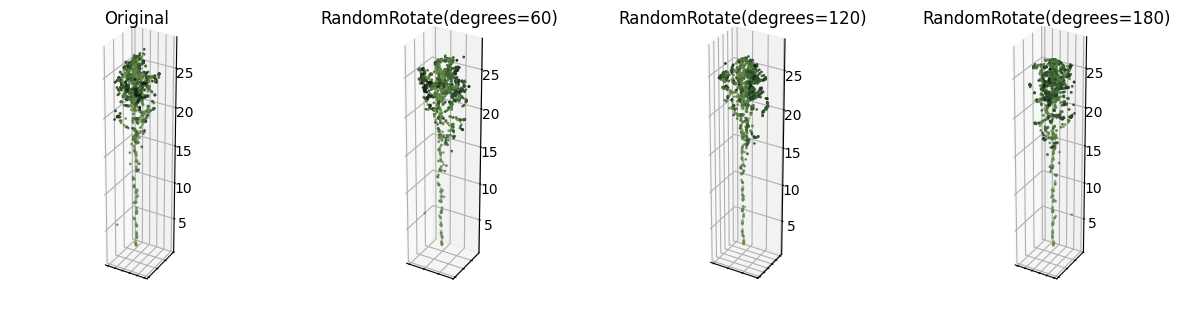

In [6]:
#| include: true
#| label: fig-random-rotate-effect
#| fig-cap: |
#|   Visualization of the random rotation around Z axis augmentation on a single aspen
#|   tree. The effect is forced to happen with full amplitude for visualization purposes,
#|   during training a rotation angle is uniformly sampled from a set range.

fig = plt.figure(figsize=(15, 10))

params = [
    (0, 0),
    (60, 60),
    (120, 120),
    (180, 180),
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomRotate(x, axis=2)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
    else:
        ax.set_title(f"RandomRotate(degrees={x[0]})")
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

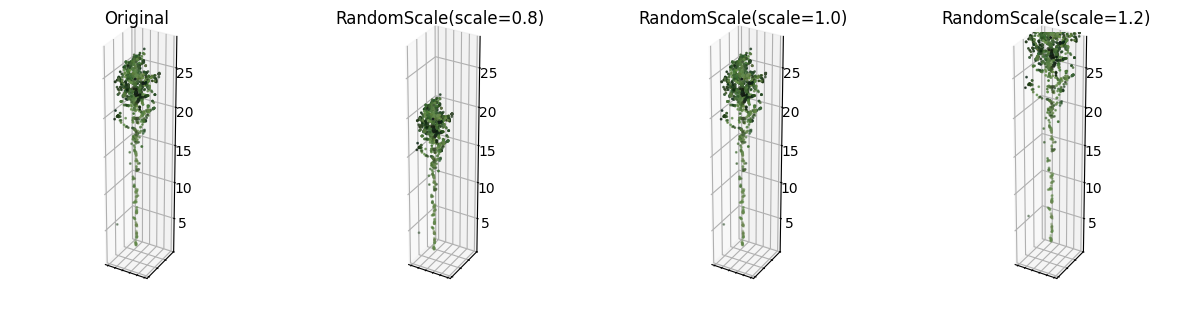

In [7]:
#| include: true
#| label: fig-random-scale-effect
#| fig-cap: |
#|   Visualization of the random scale augmentation on a single aspen tree.
#|   The effect is forced to happen with full amplitude for visualization purposes,
#|   during training a scale factor is uniformly sampled from a set range.

fig = plt.figure(figsize=(15, 10))

params = [
    (1, 1),
    (0.8, 0.8),
    (1.0, 1.0),
    (1.2, 1.2),
]

for i, x in enumerate(params, start=1):
    ax = fig.add_subplot(1, len(params), i, projection="3d")
    transformed = torch_geometric.transforms.RandomScale(x)(data)
    ax = src.visualization.clouds.scatter_point_cloud_3d(
        xyz=transformed.pos.numpy(),
        color=rgb,
        ax=ax,
    )
    if i == 1:
        ax.set_title("Original")
        xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    else:
        ax.set_title(f"RandomScale(scale={x[0]})")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
    ax.set_aspect("equal")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

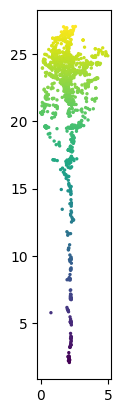

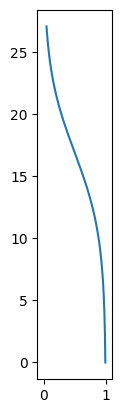

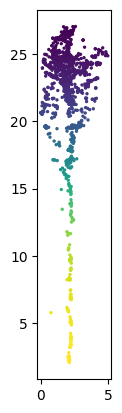

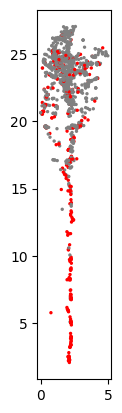

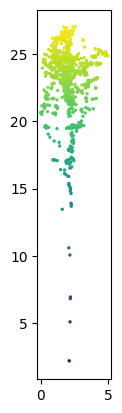

In [8]:
#| include: true
#| label: fig-height-dropout
#| layout-ncol: 5
#| fig-cap: |
#|   Effect of the height-dependent modified sigmoid dropout on a single aspen tree.
#| fig-subcap:
#|   - A single aspen tree with points colored by height.
#|   - Height-dependent probability of dropout (a modified sigmoid).
#|   - The same aspen with points colored by probability of dropout.
#|   - The same aspen with points that will be dropped marked red.
#|   - The same aspen after the dropout is appleid with point colored by height.

rng = np.random.default_rng(seed=42)

scale, shift = 8, 3
xyz = las.xyz

height = xyz[:, 2]
normalized_height = height / height.max()
reversed_normalized_height = 1 - normalized_height
threshold = 1 / (1 + np.exp(-reversed_normalized_height * scale + shift))
mask = threshold < rng.uniform(size=height.size)

xx = np.linspace(0, 1, 1001)
yy = 1 / (1 + np.exp(-xx * scale + shift))
max_x, _, max_z = np.max(xyz, axis=0)
min_x, _, min_z = np.min(xyz, axis=0)
aspect = (max_x - min_x) / (max_z - min_z)

src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XZ",
    sort_by_height=False,
)

fig, ax = plt.subplots()
ax.plot(yy[::-1], xx * max_z)
ax.set_xlim(-0.1, 1.1)
ax.set_aspect(aspect)

src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XZ",
    sort_by_height=False,
    color=threshold,
)
ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz,
    projection="XZ",
    sort_by_height=False,
    color=mask,
    cmap=ListedColormap(["red", "gray"]),
)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax = src.visualization.clouds.scatter_point_cloud_2d(
    xyz=xyz[mask],
    projection="XZ",
    sort_by_height=False,
)
ax.set_xlim(xlim)
ax.set_ylim(ylim);